The purpose of this notebook is to show how to use Qiskit's `Parameter` object to create and manipulated PQCs.

In [6]:
import sys
sys.path.append('../Pyfiles')

import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [7]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

In [9]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

%matplotlib inline
from optimizer import *

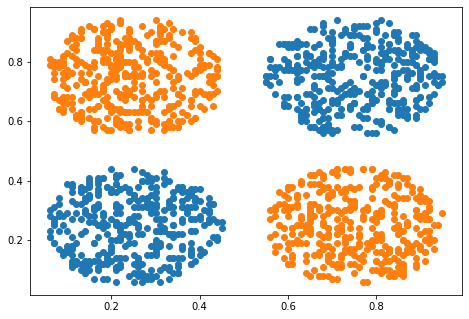

In [10]:
dataID = '2a'
dataPath = r'../dataset/data{0}.txt'.format(dataID)
dataLabel = r'../dataset/data{0}label.txt'.format(dataID)

dataCoords = np.loadtxt(dataPath)
dataLabels = np.loadtxt(dataLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = np.array(shuffle(data), dtype='object')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [11]:
shuffled_data

array([[array([0.18, 0.28]), -1.0],
       [array([0.11, 0.33]), -1.0],
       [array([0.17, 0.35]), -1.0],
       ...,
       [array([0.38, 0.75]), 1.0],
       [array([0.78, 0.69]), -1.0],
       [array([0.68, 0.42]), 1.0]], dtype=object)

Below is a 2-qubit circuit that's built using the `Parameter` object.

We're going to make a circuit that includes both the embedding and variational pieces.

In [6]:
x0 = Parameter('x0')
x1 = Parameter('x1')

t0 = Parameter('t0')
t1 = Parameter('t1')
t2 = Parameter('t2')
t3 = Parameter('t3')


qc = QuantumCircuit(2)

qc.rx(x0, 0)
qc.rx(x1, 1)


qc.ry(np.pi/4, range(qc.width()))
qc.rz(np.pi/4, range(qc.width()))

qc.rx(t0, 0)
qc.rz(t1, 0)

qc.rx(t2, 1)
qc.rz(t3, 1)


qc.draw()

┌────────┐┌─────────┐┌─────────┐┌────────┐┌────────┐
q_0: ┤ RX(x0) ├┤ RY(π/4) ├┤ RZ(π/4) ├┤ RX(t0) ├┤ RZ(t1) ├
     ├────────┤├─────────┤├─────────┤├────────┤├────────┤
q_1: ┤ RX(x1) ├┤ RY(π/4) ├┤ RZ(π/4) ├┤ RX(t2) ├┤ RZ(t3) ├
     └────────┘└─────────┘└─────────┘└────────┘└────────┘

This circuit forms the basic construct used below.

In particular, using the `.bind_parameters` method of `qc`, we can replace the parameter values by numeric ones.

In [7]:
def calc_probs_from_results(counts, converter_dict):
    r'''Given a Qiskit `counts` object (i.e., a dictionary containing
    bitstrings and outcome probabilities), make an assignment to the
    probabilities of a +/- 1 label.'''
    
    probsPlus = 0
    probsMinus = 0

    for k in converter_dict.keys():
        if converter_dict[k] == 1:
            probsPlus += counts[k]
        else:
            probsMinus += counts[k]
            
    return probsPlus, probsMinus

def label_assignment(probsPlus, probsMinus):
    r'''Given the probabilities of +/- 1, declare the
    label which should be assigned'''
    
    if probsPlus > probsMinus:
        label = 1
    elif probsMinus > probsPlus:
        label = -1
    else:
        # An edge case: if the probs are equal, just return a random label
        label= 2*np.random.binomial(1, .5) -1
    
    return label

def prediction_loss(label, prediction):
    
    return np.abs(label - prediction)

def loss(params, paramNames, dataCircuits, converter_dict):
    r'''Function which computes the loss.
    
    Inputs:
       params: The particular parameter values
       paramNames: The name of the parameters
       dataCircuits: List of partially-parameterized circuits
       converter_dict: A dictionary representing how to map from bitstrings to labels
    
    Outputs:
       The loss
    '''
    
    # Bind the variables for the classifier part of the circuit
    fully_bound_qcs = [d.bind_parameters(dict(zip(paramNames, params)))for d in dataCircuits]

    # Run all the circuits
    job = be.run(fully_bound_qcs)

    # Get the counts
    counts = job.result().get_counts()

    # Now, calculate the probabilities of the +/- 1 outcome
    probsList = [calc_probs_from_results(C, converter_dict) for C in list(counts)]

    # Do the label assignment
    predictions_list = [label_assignment(P[0], P[1]) for P in probsList]

    # Calculate the loss on each data point
    prediction_loss_list = [prediction_loss(data[j][1], predictions_list[j]) for j in range(len(predictions_list))]

    # Sum it up and return
    return np.sum(prediction_loss_list)

In [8]:
# Converter dictionary for 2-qubit circuit.
two_q_converter_dict = {'00': 1, '01': -1, '10': -1, '11': 1}

# We'll use the statevector simulator, to get the
# exact outcome probabilities.
be = Aer.get_backend('statevector_simulator')

In [12]:
#load the SPSA optimizer from the optimizer.py file
from optimizer import *

# Training

Use the SPSA algorithm to do the training.

In [10]:

c = 1
a = c/5

currentParams = np.random.uniform(-np.pi, np.pi, size=4)

lossList = []
cList = []
aList = []
paramsList = []


for j in range(125):
    print(j)
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)
    aList.append(aj)
    cList.append(cj)

    np.random.seed(j)
    data_ixs = np.random.choice(len(shuffled_data), size=750)
    data_set = shuffled_data[data_ixs]

    # Generate a list of circuits whose parameters are partially bound,
    # based on the data set.
    dataCircuits = [qc.bind_parameters({x0:X[0][0], x1:X[0][1]}) for X in data_set]

    # Use a lambda function to make a call to the loss function
    # where the only thing which changes is the parameter values
    # for the classification part of the circuit.
    L = lambda x: loss(x, [t0, t1, t2, t3], dataCircuits, two_q_converter_dict)

    lossList.append(L(currentParams))

    # Update the parameters
    currentParams = SPSA_update(L, currentParams, aj, cj)     

    paramsList.append(currentParams)

lossList.append(L(currentParams))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


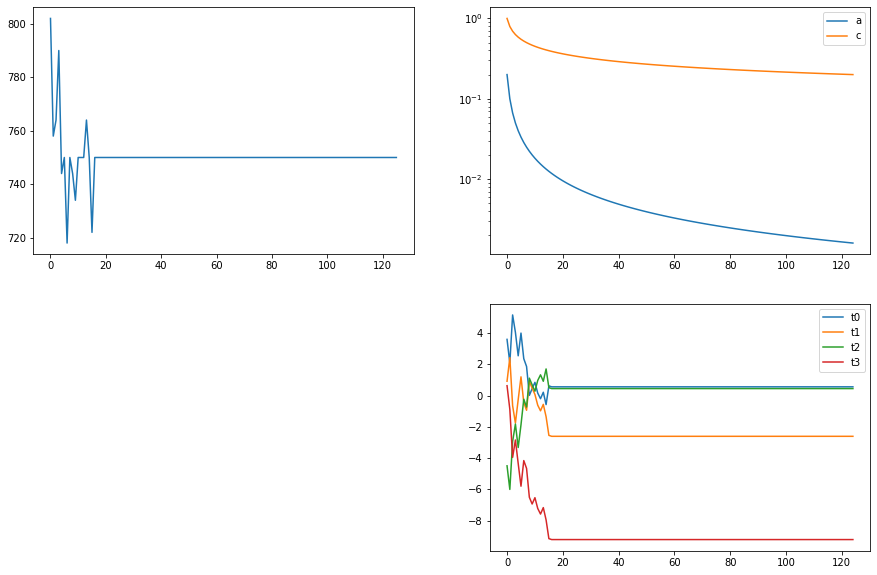

In [11]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)

ax = fig.add_subplot(2, 2, 2)
ax.plot(aList, label='a')
ax.plot(cList, label='c')
ax.legend(loc=0)
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 4)
for j in range(len(paramsList[0])):
    ax.plot([p[j] for p in paramsList], label='t{0}'.format(j))
ax.legend(loc=0)

# Visualization of results

NameError: name 'trained_qc' is not defined

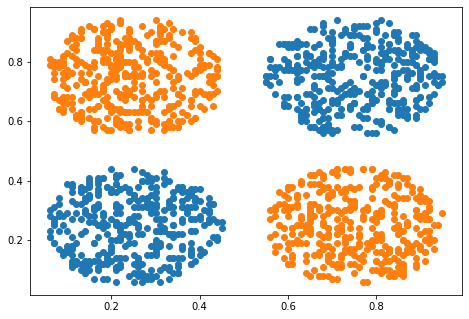

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        job = be.run(trained_qc.bind_parameters({x0: X[k], x1: X[j]}))
        counts = job.result().get_counts()
        probsPlus, probsMinus = calc_probs_from_results(counts, two_q_converter_dict)
        Z[j, k] = label_assignment(probsPlus, probsMinus)
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)